# RCT人工データ

In [3]:
import warnings
warnings.filterwarnings('error')
import pandas as pd
import numpy as np
from load_data import ArtificialData
from model import CFR
from optimize import MMD, train
from matplotlib import pyplot as plt
from dowhy import CausalModel

import torch
from torch.utils.data import DataLoader
from econml.dml import CausalForestDML
from sklearn.linear_model import LassoCV, LinearRegression
from sklearn.model_selection import train_test_split

### 人口データを用いた実験

In [4]:
# TODO: もう少し結果の見方を工夫する。可視化している結果が意味ない。
def view_causality_data_and_result(D, net, losses, legend=True):
    with torch.no_grad():
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 3))

#         ax1.set_title('potential outcomes')
#         ax1.set_ylabel('$y$')
#         ax1.set_xlabel('$x$')
#         ax1.plot(D.X, D.mu0, label='$mu_0$', color='blue')
#         ax1.plot(D.X, D.mu1, label='$mu_1$', color='orange')

#         tau = D.mu1 - D.mu0
#         N = D.X.shape[0]
#         tau_hat = net(D.X, torch.ones(N))[1] - net(D.X, torch.zeros(N))[1]
#         ax2.set_ylabel('effect')
#         ax2.set_xlabel('$x$')
#         ax2.set_title('ground vs estimate for effect')
#         ax2.plot(D.X, tau, color='blue', label='ground')
#         ax2.plot(D.X, tau_hat, color='orange', label='predict')

        ax3.set_title('train loss')
        ax3.set_ylabel('loss')
        ax3.set_xlabel('steps')
        ax3.plot(losses)
        
        if legend:
            fig.legend()
        fig.tight_layout()
        plt.show()

In [5]:
# データの読み込み
ad_train_D = ArtificialData(mode=0, N=1000, seed=0)  # 訓練データ, mode=RCT, 定数効果
ad_test_D = ArtificialData(mode=0, N=1000, seed=1)  # テストデータ, mode=RCT, 定数効果
ate_true = torch.mean(ad_test_D.mu1 - ad_test_D.mu0)

shape check has been done.
shape check has been done.


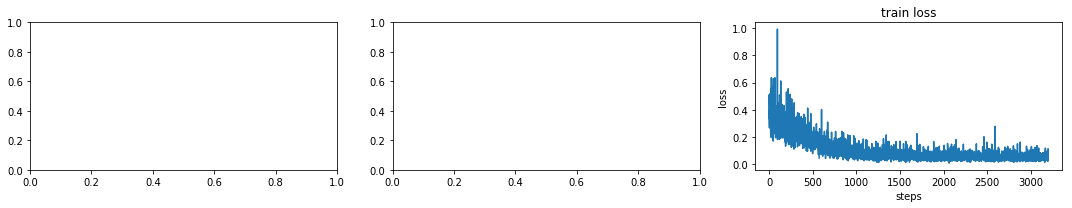

In [6]:
# CFR-NETの訓練
train_loader = DataLoader(ad_train_D, batch_size=32, shuffle=True)
cfr_net = CFR(feature_dim=2)
# FIXME: 損失がうまく低下しない, 考えられる可能性
#    1) 実装が間違っている。
#    2) そもそも解けない問題を解いている。
model, train_losses, _ = train(cfr_net, train_loader, learning_rate=1e-5, alpha=0.1, seed=100, epoch=100)
view_causality_data_and_result(ad_train_D, model, train_losses, legend=False)

In [7]:
# 結果の評価
def f_treat(X, N):
    '''^f(x, 1)を算出'''
    return cfr_net(X, torch.ones(N))[1]


def f_control(X, N):
    '''^f(x, 0)を算出'''
    return cfr_net(X, torch.zeros(N))[1]


def loss_pehe(y_treat_hat, y_control_hat, mu1, mu0):
    effect_hat = y_treat_hat - y_control_hat  # 効果の推定量
    effect_true = mu1 - mu0  # 真の効果
    return torch.sqrt(torch.mean((effect_hat - effect_true)**2))


def loss_ate(y_treat_hat, y_control_hat, mu1, mu0):
    effect_hat = y_treat_hat - y_control_hat  # 効果の推定量
    effect_true = mu1 - mu0  # 真の効果
    ate_hat = torch.mean(effect_hat)  # ATEの推定量
    ate_true = torch.mean(effect_true)  # 真のATE
    return torch.abs(ate_hat - ate_true)


def evaluation(D, fname):
    # potential outcomeの推定
    y_treat_hat = f_treat(D.X, D.N)
    y_control_hat = f_control(D.X, D.N)

    # \epsilon_{PEHE}を算出
    pehe = loss_pehe(y_treat_hat, y_control_hat, D.mu1, D.mu0)

    # \epsilon_{ATE}を算出
    ate_error = loss_ate(y_treat_hat, y_control_hat, D.mu1, D.mu0)

    # 結果の表示
    print('pehe = ', pehe.item())
    print('error of ate =', ate_error.item())

    # 結果の保存
    torch.save({
        'X_test': D.X,
        'pehe': pehe,
        'ate_error': ate_error,
    }, fname)

In [8]:
# Out of Sample
N = ad_test_D.X.shape[0]
estimate_cfr_net = torch.mean(cfr_net(ad_test_D.X, torch.ones(N))[1] - cfr_net(ad_test_D.X, torch.zeros(N))[1]).item()
print('ATE estimate of CFR-NET: ', estimate_cfr_net)

ATE estimate of CFR-NET:  0.21301694214344025


In [9]:
evaluation(ad_train_D, 'results/rct_cfr_net_WS.pt')

pehe =  0.11916590481996536
error of ate = 0.08486156165599823


In [10]:
evaluation(ad_test_D, 'results/rct_cfr_net_OoS.pt')

pehe =  0.12174015492200851
error of ate = 0.08698306977748871
